<a href="https://colab.research.google.com/github/thxrxsh/SENTRINET/blob/main/sentrinet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Setup and data loading

In [ ]:
!git clone https://github.com/thxrxsh/SENTRINET.git && mv -v SENTRINET/NSL_KDD/ NSL_KDD && rm -rf SENTRINET

Cloning into 'SENTRINET'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (18/18), 2.42 MiB | 4.05 MiB/s, done.
Resolving deltas: 100% (1/1), done.
renamed 'SENTRINET/NSL_KDD/' -> 'NSL_KDD'


In [10]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
train_data = pd.read_csv('NSL_KDD/KDDTrain+.csv', header=None)
test_data = pd.read_csv('NSL_KDD/KDDTest+.csv', header=None)

# Assign column names based on NSL-KDD dataset documentation
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level'
]


train_data.columns = column_names
test_data.columns = column_names

# Combine train and test data for preprocessing
data = pd.concat([train_data, test_data])

# List unique attack types
print("Unique attack types before mapping:", data['attack'].unique())

Unique attack types before mapping: ['normal' 'neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap'
 'satan' 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop'
 'rootkit' 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land'
 'loadmodule' 'spy' 'perl' 'saint' 'mscan' 'apache2' 'snmpgetattack'
 'processtable' 'httptunnel' 'ps' 'snmpguess' 'mailbomb' 'named'
 'sendmail' 'xterm' 'worm' 'xlock' 'xsnoop' 'sqlattack' 'udpstorm']


## 2. Feature Manipulating

#### Map targets (Attacks) in to categories

In [12]:

# Map attack types to categories
attack_mapping = {
    'normal': 'Normal',
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS',
    'apache2': 'DoS', 'udpstorm': 'DoS', 'processtable': 'DoS', 'mailbomb': 'DoS',
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L', 'phf': 'R2L', 'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L',
    'snmpgetattack': 'R2L', 'httptunnel': 'R2L', 'named': 'R2L', 'sendmail': 'R2L', 'xsnoop': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'ps': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R',
    'worm': 'U2R', 'snmpguess': 'U2R',
    'warezclient': 'R2L', 'multihop': 'R2L', 'named': 'R2L', 'sendmail': 'R2L', 'xlock': 'R2L',
    'xsnoop': 'R2L'
}



# Apply the attack mapping to the dataset
data['attack'] = data['attack'].map(attack_mapping)

# Verify the mapping
print("After mapping, unique attack types in the combined data:", data['attack'].unique())

unmapped_attacks = data[data['attack'].isna()]['attack'].unique()
print("Unmapped attack types:", unmapped_attacks)


After mapping, unique attack types in the combined data: ['Normal' 'DoS' 'R2L' 'Probe' 'U2R']
Unmapped attack types: []


#### Convert Non-Numerical data columns in to numerical data

'protocol_type', 'service', 'flag', 'attack' columns contain non-numerical data. Hence we need to convert those values in to numerical data for model training

In [18]:
# Encode categorical features
categorical_cols = ['protocol_type', 'service', 'flag', 'attack']
le = LabelEncoder()
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

# Standardize numerical features
scaler = StandardScaler()
# Exclude 'attack' and 'level' from numerical columns since they are the target variables
numerical_cols = data.columns.drop(['attack', 'level'])
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])



#### Split data using train_test_split   (Option 1)

In [19]:
from sklearn.model_selection import train_test_split

X = data.drop(['attack', 'level'], axis=1)
y = data['attack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Split the combined data back into training and testing sets (Option 2)

In [ ]:
X_train = data.iloc[:train_data.shape[0], :-2]  # Features (exclude 'attack' and 'level')
y_train = data.iloc[:train_data.shape[0], -2]   # Target 'attack'
X_test = data.iloc[train_data.shape[0]:, :-2]   # Features (exclude 'attack' and 'level')
y_test = data.iloc[train_data.shape[0]:, -2]    # Target 'attack'

## 3. Model training

### Apply RandomForestClassfier

In [21]:
# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)


#### Classification report

In [22]:
# Create a dictionary for attack type names
attack_names = {
    0: 'DoS',
    1: 'Normal',
    2: 'Probe',
    3: 'R2L',
    4: 'U2R',
}

# Print the classification report for RandomForestClassifier
print(classification_report(y_test, y_pred, target_names=[attack_names[i] for i in sorted(attack_names.keys())]))

              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     10683
      Normal       0.99      1.00      1.00     15345
       Probe       1.00      1.00      1.00      2845
         R2L       0.97      0.92      0.95       745
         U2R       0.99      0.88      0.93        86

    accuracy                           1.00     29704
   macro avg       0.99      0.96      0.97     29704
weighted avg       1.00      1.00      1.00     29704



#### Confision Matrix

<Figure size 1200x1000 with 0 Axes>

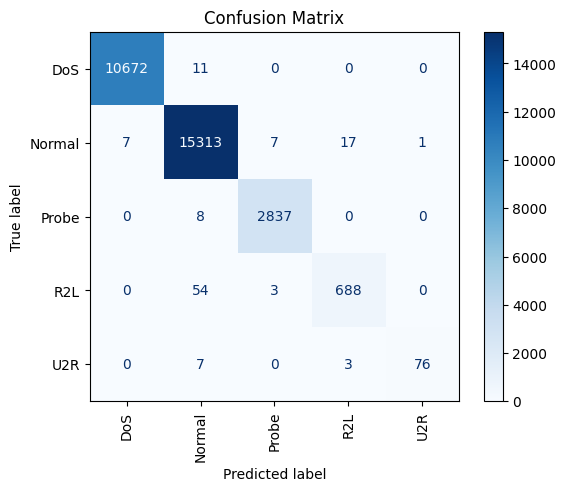

In [23]:
# Generate the confusion matrix for RandomForestClassifier
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

#### Featuer Importances

In [24]:
# Get feature importances
importances = clf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the top features
print("Top features by importance:")
print(feature_importances.head(20))

Top features by importance:
                        Feature  Importance
4                     src_bytes    0.154562
28                same_srv_rate    0.070301
3                          flag    0.065502
5                     dst_bytes    0.061806
22                        count    0.061712
24                  serror_rate    0.055525
25              srv_serror_rate    0.044385
29                diff_srv_rate    0.042597
33       dst_host_same_srv_rate    0.039688
35  dst_host_same_src_port_rate    0.038921
34       dst_host_diff_srv_rate    0.034357
1                 protocol_type    0.033785
23                    srv_count    0.031582
38     dst_host_srv_serror_rate    0.031420
2                       service    0.030824
32           dst_host_srv_count    0.028298
39         dst_host_rerror_rate    0.024162
11                    logged_in    0.021479
36  dst_host_srv_diff_host_rate    0.019743
37         dst_host_serror_rate    0.017088


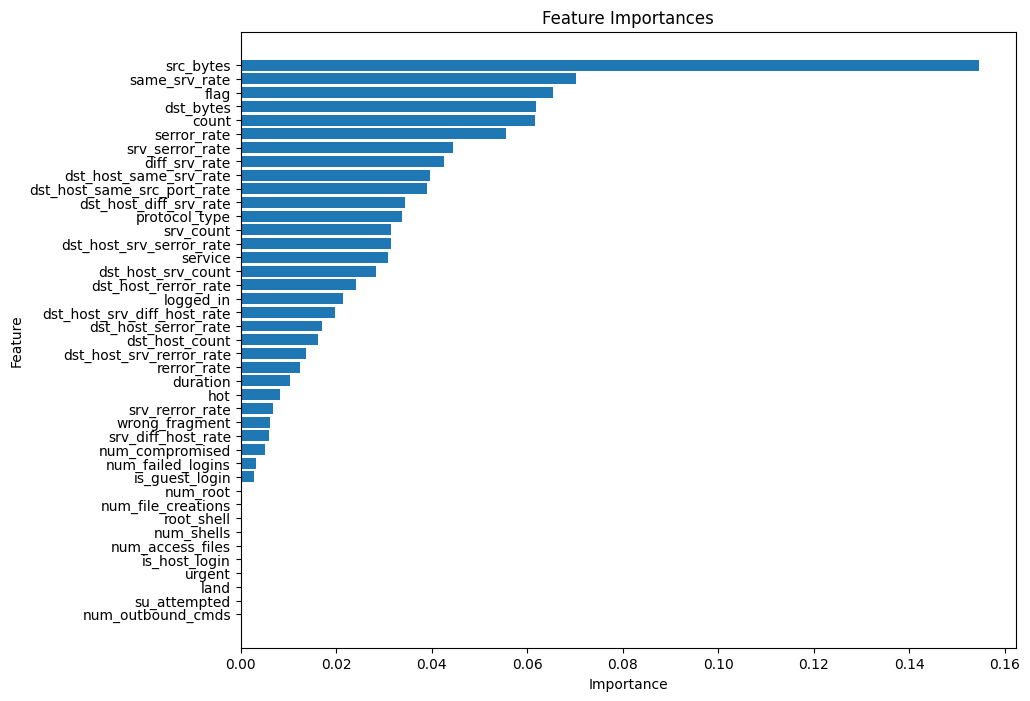

In [25]:
import matplotlib.pyplot as plt

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

### Apply XGBoost Algorithm

In [27]:
import xgboost as xgb

clf = xgb.XGBClassifier( scale_pos_weight={0: 1, 1: 1, 2: 1, 3: 10, 4: 10}, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:41:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


#### Classification report

In [28]:
# Create a dictionary for attack type names
attack_names = {
    0: 'DoS',
    1: 'Normal',
    2: 'Probe',
    3: 'R2L',
    4: 'U2R',
}

# Print the classification report for XGBoost
print(classification_report(y_test, y_pred, target_names=[attack_names[i] for i in sorted(attack_names.keys())]))

              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     10683
      Normal       1.00      1.00      1.00     15345
       Probe       1.00      1.00      1.00      2845
         R2L       0.97      0.94      0.96       745
         U2R       0.99      0.91      0.95        86

    accuracy                           1.00     29704
   macro avg       0.99      0.97      0.98     29704
weighted avg       1.00      1.00      1.00     29704



#### Confision Matrix

<Figure size 1200x1000 with 0 Axes>

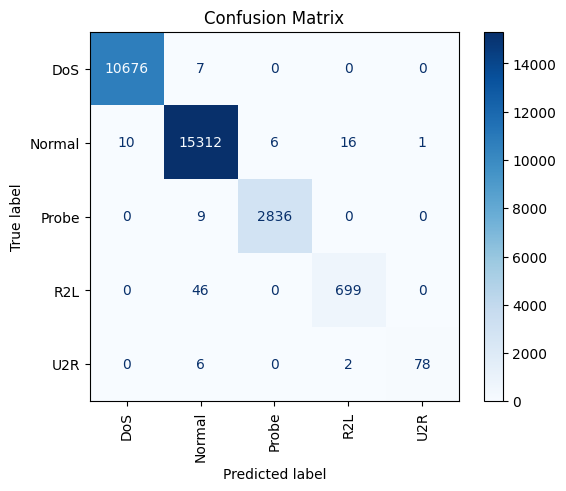

In [29]:
# Generate the confusion matrix for XGBoost
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

#### Featuer Importances

In [30]:
# Get feature importances
importances = clf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the top features
print("Top features by importance:")
print(feature_importances.head(20))

Top features by importance:
                        Feature  Importance
28                same_srv_rate    0.298658
4                     src_bytes    0.086029
21               is_guest_login    0.078497
29                diff_srv_rate    0.061620
36  dst_host_srv_diff_host_rate    0.058584
22                        count    0.051028
38     dst_host_srv_serror_rate    0.045789
10            num_failed_logins    0.042932
7                wrong_fragment    0.041356
1                 protocol_type    0.034642
34       dst_host_diff_srv_rate    0.023850
24                  serror_rate    0.019162
26                  rerror_rate    0.016892
3                          flag    0.013276
9                           hot    0.012729
2                       service    0.011591
5                     dst_bytes    0.009956
33       dst_host_same_srv_rate    0.009800
37         dst_host_serror_rate    0.009751
6                          land    0.007970


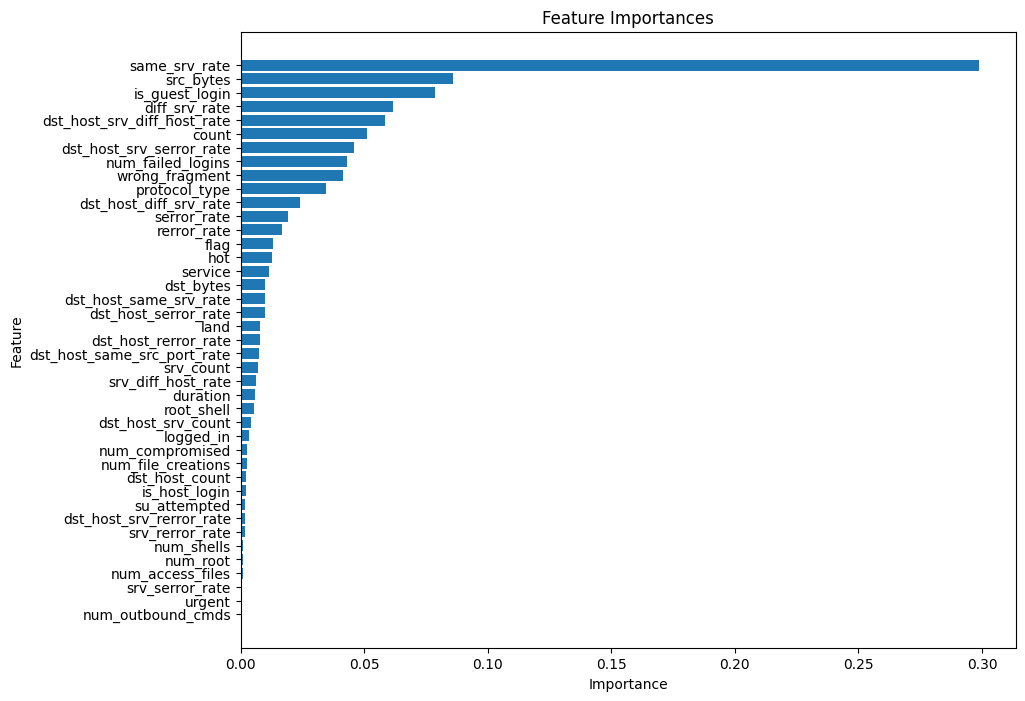

In [31]:
import matplotlib.pyplot as plt

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()